In [1]:
cd /content/drive/MyDrive/Git/exercise/Code

/content/drive/MyDrive/Git/exercise/Code


# Module import

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from tqdm import tqdm

# Data Prepare

## Merge monthly CSV


체력 측정별 운동 처방, 체력측정 항목별 측정 데이터는 월 단위로 csv파일이 업로드 됨  
따라서 병합해주는 작업이 필요

### Load raw data


[사용데이터]  
https://www.culture.go.kr/bigdata/user/data_market/detail.do?id=2b1c565d-5f37-4152-966d-5f8094f8cf33  

https://www.culture.go.kr/bigdata/user/data_market/detail.do?id=ace0aea7-5eee-48b9-b616-637365d665c1


|데이터명|기간|
|-|-|
|체력 측정별 운동처방 데이터 | 2017.01 ~ 2021.12 |
|체력측정 항목별 측정 데이터 | 2017.01 ~ 2021.12 |

In [3]:
# Data의 Raw 폴더에서 측정별 운동 처방 데이터와, 항목별 측정 데이터를 각각 mvm_list, item_list에 불러와 mvm_df, item_df로 병합
dir_path = "../Data/Raw/"
mvm_list = []
item_list = []
for (root, _, files) in os.walk(dir_path):
    for file in files:
        if 'MVM' in file:
            mvm_list.append(pd.read_csv(root+file))
        elif 'ITEM' in file:
            item_list.append(pd.read_csv(root+file))

mvm_df_origin = pd.concat(mvm_list, ignore_index=True)
item_df_origin = pd.concat(item_list, ignore_index=True)

In [4]:
print(f'mvm_df_origin.shape : {mvm_df_origin.shape}, item_df_origin : {item_df_origin.shape}')

mvm_df_origin.shape : (878353, 10), item_df_origin : (1016314, 50)


## Column selection

### item Column Definition

https://www.culture.go.kr/bigdata/user/data_market/detail.do?id=ace0aea7-5eee-48b9-b616-637365d665c1

In [50]:
# 체력측정 항목별 측정 데이터 컬럼 정의서 Load
# item_column_df = pd.read_excel(dir_path+'체력측정 항목별 측정 데이터_컬럼정의서.xls')[['컬럼영문명','컬럼한글명']]
item_column_df = pd.read_csv(dir_path+'체력측정 항목별 측정 데이터_컬럼정의서.csv')[['컬럼영문명','컬럼한글명']]
item_column_df['컬럼한글명'] = item_column_df['컬럼한글명'].apply(lambda x : x.replace('측정항목값 : ',''))
item_column_df = item_column_df.T
item_column_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
컬럼영문명,TEST_CNT,CENTER_NM,AGE_GBN,TEST_GBN,TEST_AGE,INPUT_GBN,CERT_GBN,TEST_YMD,TEST_SEX,ITEM_F001,ITEM_F002,ITEM_F003,ITEM_F004,ITEM_F005,ITEM_F006,ITEM_F007,ITEM_F008,ITEM_F009,ITEM_F010,ITEM_F011,ITEM_F012,ITEM_F013,ITEM_F014,ITEM_F015,ITEM_F016,ITEM_F017,ITEM_F018,ITEM_F019,ITEM_F020,ITEM_F021,ITEM_F022,ITEM_F023,ITEM_F024,ITEM_F025,ITEM_F026,ITEM_F027,ITEM_F028,ITEM_F029,ITEM_F030,ITEM_F031,ITEM_F032,ITEM_F033,ITEM_F034,ITEM_F035,ITEM_F036,ITEM_F037,ITEM_F038,ITEM_F039,ITEM_F040,ITEM_F041
컬럼한글명,측정 회차,센터명,나이구분,측정구분,측정나이,입력구분,상장구분,측정일,측정회원성별,신장 : cm,체중 : kg,체지방율 : %,허리둘레 : cm,이완기혈압(최저) : mmHg,수축기혈압(최고) : mmHg,악력D : kg,악력ND : kg,윗몸말아올리기 : 회,반복점프 : 회,미정,앉아윗몸앞으로굽히기 : cm,일리노이 : 초,체공시간 : 초,협응력시간 : 초,협응력실수횟수 : 회,협응력계산결과값 : 초,BMI : kg/㎡,교차윗몸일으키기 : 회,왕복오래달리기 : 회,10M 4회 왕복달리기 : 초,제자리 멀리뛰기 : cm,의자에앉았다일어서기 : 회,6분걷기 : m,2분제자리걷기 : 회,의자에앉아 3M표적 돌아오기 : 초,8자보행 : 초,상대악력 : %,피두부겹합,왕복오래달리기(출력) : VO₂max,트레드밀_안정시 : bpm,트레드밀_3분 : bpm,트레드밀_6분 : bpm,트레드밀_9분 : bpm,트레드밀(출력) : VO₂max,스텝검사_회복시 심박수 : bpm,스텝검사(출력) : VO₂max,허벅지(좌),허벅지(우),전신반응 : 초,체공시간2 : 초


### Drop the mvm columns

In [6]:
mvm_df_origin.head(3)

,TEST_CNT,CENTER_NM,AGE_GBN,TEST_GBN,TEST_AGE,INPUT_GBN,CERT_GBN,TEST_YMD,PRES_NOTE,TEST_SEX
0,1,남구(부산),청소년,출장,14,관리자,참가증,20210706,"본운동:엎드려 버티기,옆으로 누워 버티기,누워서 엉덩이 들어올리기,팔굽혀펴기,네발기...",F
1,1,남구(부산),청소년,출장,15,관리자,1등급,20210706,"준비운동:팔벌려뛰기,버피운동,한발 앞으로 내밀고 앉았다 일어서기,서서 균형잡기,옆으...",F
2,1,남구(부산),청소년,출장,15,관리자,2등급,20210706,"준비운동:팔벌려뛰기,버피운동,한발 앞으로 내밀고 앉았다 일어서기,서서 균형잡기,옆으...",M


In [7]:
mvm_df = mvm_df_origin.drop(['TEST_GBN','INPUT_GBN'],axis=1)

In [8]:
mvm_df.head(3)

,TEST_CNT,CENTER_NM,AGE_GBN,TEST_AGE,CERT_GBN,TEST_YMD,PRES_NOTE,TEST_SEX
0,1,남구(부산),청소년,14,참가증,20210706,"본운동:엎드려 버티기,옆으로 누워 버티기,누워서 엉덩이 들어올리기,팔굽혀펴기,네발기...",F
1,1,남구(부산),청소년,15,1등급,20210706,"준비운동:팔벌려뛰기,버피운동,한발 앞으로 내밀고 앉았다 일어서기,서서 균형잡기,옆으...",F
2,1,남구(부산),청소년,15,2등급,20210706,"준비운동:팔벌려뛰기,버피운동,한발 앞으로 내밀고 앉았다 일어서기,서서 균형잡기,옆으...",M


### Drop the item columns

In [9]:
item_df_origin.head(3)

,TEST_CNT,CENTER_NM,AGE_GBN,TEST_GBN,TEST_AGE,INPUT_GBN,CERT_GBN,TEST_YMD,TEST_SEX,ITEM_F001,ITEM_F002,ITEM_F003,ITEM_F004,ITEM_F005,ITEM_F006,ITEM_F007,ITEM_F008,ITEM_F009,ITEM_F010,ITEM_F011,ITEM_F012,ITEM_F013,ITEM_F014,ITEM_F015,ITEM_F016,ITEM_F017,ITEM_F018,ITEM_F019,ITEM_F020,ITEM_F021,ITEM_F022,ITEM_F023,ITEM_F024,ITEM_F025,ITEM_F026,ITEM_F027,ITEM_F028,ITEM_F029,ITEM_F030,ITEM_F031,ITEM_F032,ITEM_F033,ITEM_F034,ITEM_F035,ITEM_F036,ITEM_F037,ITEM_F038,ITEM_F039,ITEM_F040,ITEM_F041
0,2,동작,성인,일반,19.0,관리자,참가증,20210909,M,165.6,75.4,32.8,85.0,82.0,124.0,33.0,32.5,NaN,NaN,NaN,-10.7,NaN,NaN,NaN,NaN,NaN,27.5,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.0,46.1,NaN,NaN,0.354,0.551
1,2,KSPO광주,성인,일반,22.0,관리자,3등급,20210909,M,185.0,83.0,13.9,87.8,65.0,121.0,NaN,51.6,NaN,NaN,NaN,16.8,NaN,NaN,NaN,NaN,NaN,24.3,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,48.2,NaN,NaN,0.364,0.603
2,1,창원마산회원,성인,출장,20.0,관리자,2등급,20210909,M,165.6,62.1,17.0,NaN,60.0,121.0,46.4,50.9,NaN,NaN,NaN,21.3,NaN,NaN,NaN,NaN,NaN,22.6,75.0,NaN,NaN,226.0,NaN,NaN,NaN,NaN,NaN,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,51.1,NaN,NaN,0.337,NaN


In [10]:
item_df = item_df_origin[['TEST_CNT', 'CENTER_NM', 'AGE_GBN', 'TEST_AGE', 'CERT_GBN','TEST_YMD', 'TEST_SEX','ITEM_F001','ITEM_F002','ITEM_F018']]

In [11]:
item_df.head(3)

,TEST_CNT,CENTER_NM,AGE_GBN,TEST_AGE,CERT_GBN,TEST_YMD,TEST_SEX,ITEM_F001,ITEM_F002,ITEM_F018
0,2,동작,성인,19.0,참가증,20210909,M,165.6,75.4,27.5
1,2,KSPO광주,성인,22.0,3등급,20210909,M,185.0,83.0,24.3
2,1,창원마산회원,성인,20.0,2등급,20210909,M,165.6,62.1,22.6


## Merge MVM & ITEM

Unique ID가 존재하지 않기 때문에 기준열에서 중복되는 항목 모두 제거

In [12]:
mvm_drop = mvm_df.drop_duplicates(['TEST_CNT', 'CENTER_NM', 'AGE_GBN', 'TEST_AGE', 'CERT_GBN', 'TEST_YMD', 'TEST_SEX'],keep=False).reset_index(drop=True)
item_drop = item_df.drop_duplicates(['TEST_CNT', 'CENTER_NM', 'AGE_GBN', 'TEST_AGE', 'CERT_GBN', 'TEST_YMD', 'TEST_SEX'], keep=False).reset_index(drop=True)

In [13]:
print(mvm_drop.shape, item_drop.shape)

(415080, 8) (463532, 10)


측정별 운동 처방 데이터와, 항목별 측정 데이터 병합  
병합 완료 후 필요없어진 컬럼 제거

In [14]:
merge_df = pd.merge(mvm_drop, item_drop, on=['TEST_CNT', 'CENTER_NM', 'AGE_GBN', 'TEST_AGE', 'CERT_GBN', 'TEST_YMD', 'TEST_SEX'], how='inner')
merge_df.drop(['TEST_CNT','CENTER_NM','AGE_GBN'],axis=1,inplace=True)
print(merge_df.shape)

(414478, 8)


## Split columns - Pre, Main, Finish exercise

운동 목록에 준비운동, 본운동, 마무리운동이 하나의 컬럼으로 구성되어 있음  
이를 각각의 컬럼으로 분리하는 작업 수행  


### Exercise string to list

In [15]:
merge_df['split'] = merge_df['PRES_NOTE'].apply(lambda x : x.split(' / '))
to_list_df = merge_df.drop('PRES_NOTE',axis=1)

### Filter only 3 exercise



운동 루틴을 위해서는 3가지 운동 목록이 모두 존재해야하므로 만족하지 않는 행 제거

In [16]:
to_list_df['len_ex'] = to_list_df.apply(lambda x : len(x['split']), axis=1) # 운동 개수 열 생성
filter_df = to_list_df.loc[to_list_df['len_ex']==3].copy().drop('len_ex',axis=1).reset_index(drop=True) # 운동 개수가 3인 행만 필터링

### Split columns

In [17]:
# input : DataFrame, remove keyword
# return : Series

def split_col(df, keyword): # keyword : 준비운동, 본운동, 마무리운동
    index =  0 if keyword == '준비운동' else 1 if keyword == '본운동' else 2 if keyword =='마무리운동' else -1
    if index == -1:
        raise NameError('준비운동, 본운동, 마무리운동 이외의 값이 입력됐습니다.') 
    return df['split'].apply(lambda x : x[index].replace(keyword+':','')).copy()

In [18]:
# 컬럼 분리
pre_ex_col = split_col(filter_df, '준비운동')
main_ex_col = split_col(filter_df, '본운동')
finish_ex_col = split_col(filter_df, '마무리운동')

# 컬럼 명 변경
pre_ex_col.name = 'PRE_EX'
main_ex_col.name = 'MAIN_EX'
finish_ex_col.name = 'FINISH_EX'

## Exercise name unify


In [19]:
ex_name_dict = {'회전근개 스트레칭2':'회전근개 스트레칭','골다공증을 위한 근력운동2':'골다공증을 위한 근력운동','골다공증을 위한 근력운동1':'골다공증을 위한 근력운동','엉덩이 스트레칭2':'엉덩이 스트레칭',
                '골반 스트레칭2':'골반 스트레칭','관절염을 위한 근력운동2':'관절염을 위한 근력운동','관절염을 위한 근력운동1':'관절염을 위한 근력운동','순간반응 콘 찍기 2':'순간반응 콘 찍기',
                '마주 앉아 대퇴이두근 스트레칭2':'마주 앉아 대퇴이두근 스트레칭','2단 줄넘기':'줄넘기','1단 줄넘기':'줄넘기','줄넘기 운동':'줄넘기','대퇴이두근 스트레칭2':'대퇴이두근 스트레칭',
                '요통을 위한 스트레칭2':'요통을 위한 스트레칭','요통을 위한 스트레칭1':'요통을 위한 스트레칭','하지 루틴 스트레칭1':'하지 루틴 스트레칭','하지 루틴 스트레칭2':'하지 루틴 스트레칭',
                '계단 두 칸씩 뛰기':'계단 뛰기','계단 두발 뛰기':'계단 뛰기','계단 뛰어 오르기':'계단 뛰기','계단 한발 뛰기':'계단 뛰기','계단 뛰어 오르기':'계단 뛰기',
                '넙다리 뒤쪽 스트레칭':'넙다리 스트레칭','넙다리 안쪽 스트레칭':'넙다리 스트레칭','넙다리 앞쪽 스트레칭':'넙다리 스트레칭','목 굽힘/ 폄 I':'목 굽힘/ 폄',
                '목 굽힘/ 폄 II':'목 굽힘/ 폄','목 굽힘/ 폄 III':'목 굽힘/ 폄','누워서 배가로근 수축 I':'누워서 배가로근 수축','누워서 배가로근 수축 II':'누워서 배가로근 수축',
                '서서 다리로 탄력밴드 당기기 II':'서서 다리로 탄력밴드 당기기','서서 다리로 탄력밴드 당기기 I':'서서 다리로 탄력밴드 당기기','등척성운동-바깥돌림':'등척성운동',
                '등척성운동-벌림':'등척성운동','등척성운동-안쪽 돌림':'등척성운동','목 당기기':'목 스트레칭','목 돌리기':'목 스트레칭','목 돌림 스트레칭':'목 스트레칭',
                '바벨 잡고 들어올리기':'바벨들어올리기','버피 테스트':'버피운동','베개 밟고 교차 서기':'베개 밟고 서기','베개 밟고 대각방향으로 서기':'베개 밟고 서기','베개 밟고 두발 모아 서기':'베개 밟고 서기',
                '베개 밟고 서기':'베게 밟고 서기','베개 밟고 서기 평형성 운동 루틴 프로그램':'베개 밟고 서기', '사다리 운동  루틴프로그램':'사다리 이용 루틴 운동','실내 자전거타기':'자전거타기',
                '실외 자전거타기':'자전거타기','고정식 자전거 타기':'자전거타기','아쿠아로빅':'아쿠아로빅', '아쿠아로빅-몸 기울이기/회전하기':'아쿠아로빅', '아쿠아로빅-물누르기/올리기':'아쿠아로빅',
                '아쿠아로빅-물당기기/밀기':'아쿠아로빅','아쿠아로빅-발 닿기':'아쿠아로빅','아쿠아로빅-엉덩관절 회전하기':'아쿠아로빅','아쿠아로빅-옆구리 늘리기':'아쿠아로빅',
                '고정식 트레드밀에서 걷기':'걷기', '트레드밀에서 걷기':'걷기','조깅':'달리기','배스트레칭':'배 스트레칭','윗몸말아올리기':'윗몸 말아 올리기'}

In [20]:
# ex_name_dict을 참고하여 운동 이름을 통일
# input : DataFrame, String
# output : DataFrame

def unify_name(df, column_name):
    tmp_list = []
    for row in range(len(df)):
        ex_list = df.loc[row, column_name].split(',')
        for i in range(len(ex_list)):
            if ex_list[i] in ex_name_dict:
                ex_list[i] = ex_name_dict[ex_list[i]]
        tmp_list.append(', '.join(ex_list))
    tmp_df = df.copy()
    tmp_df[column_name] = pd.Series(tmp_list,name=column_name)
    return tmp_df


In [21]:
split_df = pd.concat([filter_df,pre_ex_col,main_ex_col,finish_ex_col],axis=1).drop('split',axis = 1)


In [22]:
from datetime import datetime

In [23]:
# ex_name_dict을 참고하여 운동 이름을 통일
# input : DataFrame
# output : DataFrame

def unify_name(df):
    tmp_list = []
    index = df.name
    column_list = df.index.values[-3:]
    for column in column_list:
        ex_list = df[column].split(',')
        for i in range(len(ex_list)):
            if ex_list[i] in ex_name_dict:
                ex_list[i] = ex_name_dict[ex_list[i]]
        df[column] = ', '.join(ex_list)
    return df

In [24]:
unify_df = split_df.apply(unify_name,axis=1)

## Missing value & Outlier 

### Missing Value

In [25]:
unify_df.isnull().sum()

TEST_AGE      0
CERT_GBN      2
TEST_YMD      0
TEST_SEX      0
ITEM_F001    19
ITEM_F002     9
ITEM_F018     7
PRE_EX        0
MAIN_EX       0
FINISH_EX     0
dtype: int64

- CERT_GBN : 상장구분
- ITEM_F001 : 신장(cm)
- ITEM_F002 : 몸무게
- ITEM_F018 : BMI


상장구분, 신장, 몸무게의 경우 신체 특성에 중요한 부분이므로 결측치이면 제거

In [26]:
unify_df[unify_df['ITEM_F002'].isnull()].head(4)


,TEST_AGE,CERT_GBN,TEST_YMD,TEST_SEX,ITEM_F001,ITEM_F002,ITEM_F018,PRE_EX,MAIN_EX,FINISH_EX
7656,22,참가증,20210914,F,153.0,NaN,286.6,유산소 운동 전 동적 루틴 스트레칭,"윗몸올리기 , 누워서 엉덩이 들어올리기, 엎드려 버티기, 서서 상체 일으키기, 앉아...",전신 루틴 스트레칭
41077,24,참가증,20210311,F,NaN,NaN,0.0,"상지 루틴 스트레칭, 하지 루틴 스트레칭, 하지 루틴 스트레칭, 전신 루틴 스트레칭...","탄력밴드 어깨 가쪽 돌림 , 서서 탄력밴드 당겨내리기/올리기, 엎드려 버티기, 누워...","목 스트레칭, 허리 스트레칭, 배 스트레칭, 짐볼을 이용한 동적 루틴 스트레칭, 작..."
54091,19,참가증,20190923,M,178.3,NaN,116.0,걷기,"앉았다 일어서기, 한발 앞으로 내밀고 앉았다 일어서기, 넙다리 스트레칭, 하지 루틴...",계단 올라갔다 내려오기
85831,17,참가증,20190524,M,150.0,NaN,201.1,"달리기, 팔 벌려 뛰기, 동적 스트레칭 루틴프로그램","버피운동, 맨몸운동 루틴프로그램, 발 바꿔 뛰기, 양발 교차 뛰기","전신 루틴 스트레칭, 하지 루틴 스트레칭, 엉덩이 스트레칭, 허리 스트레칭, 배 스트레칭"


In [27]:
unify_df[unify_df['ITEM_F001'].isnull()].head(4)


,TEST_AGE,CERT_GBN,TEST_YMD,TEST_SEX,ITEM_F001,ITEM_F002,ITEM_F018,PRE_EX,MAIN_EX,FINISH_EX
8819,18,1등급,20210917,M,NaN,69.0,0.0,"달리기, 걷기, 앉아서 밴드 잡고 몸통 돌리기, 밴드 잡고 몸통 옆으로 굽히기, 앉...",웨이트 트레이닝 루틴프로그램,"달리기, 자전거타기, 걷기"
41077,24,참가증,20210311,F,NaN,NaN,0.0,"상지 루틴 스트레칭, 하지 루틴 스트레칭, 하지 루틴 스트레칭, 전신 루틴 스트레칭...","탄력밴드 어깨 가쪽 돌림 , 서서 탄력밴드 당겨내리기/올리기, 엎드려 버티기, 누워...","목 스트레칭, 허리 스트레칭, 배 스트레칭, 짐볼을 이용한 동적 루틴 스트레칭, 작..."
62965,41,참가증,20181113,F,NaN,57.6,0.2,"계단 올라갔다 내려오기, 하지 루틴 스트레칭, 상지 루틴 스트레칭","앉았다 일어서기, 한발 앞으로 내밀고 앉았다 일어서기, 누워서 다리 들어올리기, 팔...",전신 루틴 스트레칭
63790,74,참가증,20181120,M,NaN,65.3,NaN,"달리기, 자전거타기, 걷기, 계단 올라갔다 내려오기","누워서 전신 뻗기, 목 스트레칭, 등/어깨 뒤쪽 스트레칭, 엉덩이 스트레칭, 배 스...","자전거타기, 걷기"


In [28]:
unify_df[unify_df['CERT_GBN'].isnull()]


,TEST_AGE,CERT_GBN,TEST_YMD,TEST_SEX,ITEM_F001,ITEM_F002,ITEM_F018,PRE_EX,MAIN_EX,FINISH_EX
2350,27,NaN,20210724,F,164.7,95.14,35.1,걷기,"달리기, 무릎 높여 제자리 달리기",정적 스트레칭 루틴프로그램
2422,51,NaN,20210724,F,153.4,51.60,21.9,걷기,"달리기, 무릎 높여 제자리 달리기",정적 스트레칭 루틴프로그램


In [29]:
drop_cond = (unify_df['ITEM_F001'].isnull()) | (unify_df['ITEM_F002'].isnull()) | (unify_df['CERT_GBN'].isnull())
drop_na_df = unify_df.drop(unify_df[drop_cond].index)
drop_na_df.head(4)

,TEST_AGE,CERT_GBN,TEST_YMD,TEST_SEX,ITEM_F001,ITEM_F002,ITEM_F018,PRE_EX,MAIN_EX,FINISH_EX
0,18,3등급,20210706,F,162.9,66.4,25.0,"깍지 끼고 상체 숙이기, 양팔 벌려 전신 비틀기","밴드 걸고 옆으로 누워 다리 올리기, 의자 앉아 다리로 짐볼 쥐기, 밴드 잡고 누워...","내전근 스트레칭, 대퇴사두근 스트레칭"
1,17,참가증,20210706,M,183.4,101.9,30.3,"깍지 끼고 상체 숙이기, 양팔 벌려 전신 비틀기","밴드 걸고 옆으로 누워 다리 올리기, 의자 앉아 다리로 짐볼 쥐기, 밴드 잡고 누워...","내전근 스트레칭, 대퇴사두근 스트레칭"
2,18,3등급,20210706,M,177.0,70.3,22.4,"상지 루틴 스트레칭, 하지 루틴 스트레칭","달리기, 걷기, 누워서 다리 들어올리기, 누워서 다리 좌우로 움직이기, 윗몸올리기 ...","전신 루틴 스트레칭, 배 스트레칭, 허리 스트레칭"
3,18,참가증,20210706,M,180.1,71.0,21.9,"깍지 끼고 상체 숙이기, 양팔 벌려 전신 비틀기","밴드 걸고 옆으로 누워 다리 올리기, 의자 앉아 다리로 짐볼 쥐기, 밴드 잡고 누워...","내전근 스트레칭, 대퇴사두근 스트레칭"


In [30]:
# 제거 확인
drop_na_df.isnull().sum()

TEST_AGE     0
CERT_GBN     0
TEST_YMD     0
TEST_SEX     0
ITEM_F001    0
ITEM_F002    0
ITEM_F018    0
PRE_EX       0
MAIN_EX      0
FINISH_EX    0
dtype: int64

### Outlier

In [31]:
numeric_columns = ['TEST_AGE',  'ITEM_F001', 'ITEM_F002', 'ITEM_F018']

In [32]:
# 통계값 확인
drop_na_df[numeric_columns].agg(['min','mean','median','max'])

,TEST_AGE,ITEM_F001,ITEM_F002,ITEM_F018
min,11.000000,60.100000,19.100000,7.000000
mean,43.677612,164.479253,64.847288,23.870582
median,42.000000,164.100000,63.300000,23.600000
max,118.000000,204.000000,170.120000,178.600000


#### Boxplot - Before outlier processing

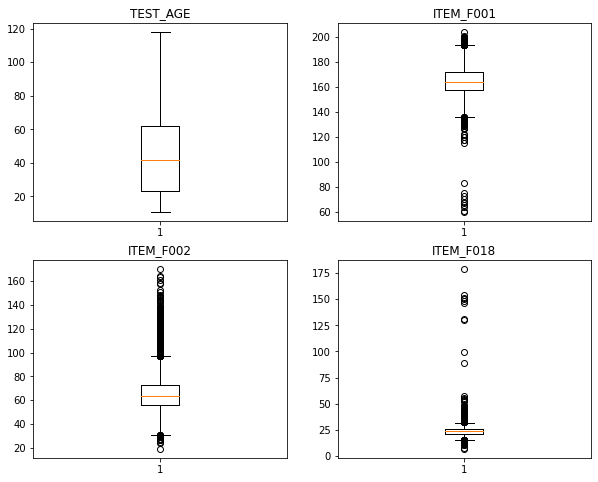

In [33]:
plt.figure(figsize=(10,8))
for i, column in enumerate(drop_na_df[numeric_columns]):
    plt.subplot(2,2,i+1)
    plt.title(column)
    plt.boxplot(drop_na_df[column])
plt.show()

#### TEST_AGE

- 100세 미만의 데이터만 사용

In [34]:
drop_na_df[drop_na_df['TEST_AGE']>100]

,TEST_AGE,CERT_GBN,TEST_YMD,TEST_SEX,ITEM_F001,ITEM_F002,ITEM_F018,PRE_EX,MAIN_EX,FINISH_EX
23885,101,참가증,20210609,F,137.6,44.3,23.4,"가슴 스트레칭, 팔꿈치 맞닿아 원그리기, 옆구리 스트레칭","의자에 앉아 볼 돌리기, 의자 이용 중심 잡기 루틴 운동, 밴드 잡고 몸통 옆으로 굽히기",대퇴이두근 스트레칭
88290,101,참가증,20190514,M,165.5,53.0,19.3,전신 루틴 스트레칭,"물통으로 양팔 들어올리기, 플렉스 바 비틀기, 벽에서 팔굽혀 펴기, 의자에 앉아 볼...",전신 루틴 스트레칭
137301,118,1등급,20181203,M,160.0,50.0,19.5,"넙다리 스트레칭, 넙다리 스트레칭, 허리 스트레칭, 배 스트레칭","몸통 비틀기, 가슴/어깨 스트레칭, 대퇴이두근 스트레칭, 엉덩이 스트레칭","허리 스트레칭, 배 스트레칭, 옆구리 스트레칭"


In [35]:
drop_na_df = drop_na_df[drop_na_df['TEST_AGE']<100].copy()

#### ITEM_F001 (Hight)

- 신장이 100 cm이하인 데이터 확인

In [36]:
drop_na_df[drop_na_df['ITEM_F001']<100]

,TEST_AGE,CERT_GBN,TEST_YMD,TEST_SEX,ITEM_F001,ITEM_F002,ITEM_F018,PRE_EX,MAIN_EX,FINISH_EX
11430,18,참가증,20211001,F,67.7,67.70,147.7,"척추 들어올리기, 동적 스트레칭 루틴프로그램","팔다리 교차 버티기, 웨이트 트레이닝 루틴프로그램, 앉았다 일어서기, 연속 사이드...","정적 스트레칭 루틴프로그램, 상체 앞으로 숙이기, 엉덩이 늘리기"
14180,53,참가증,20211216,M,83.0,68.82,99.9,유산소 운동 전 동적 루틴 스트레칭,"서서 상체 일으키기, 소파를 이용한 윗몸올리기, 네발기기 자세에서 손바닥으로 바닥밀...",전신 루틴 스트레칭
20958,70,1등급,20211103,F,60.2,32.20,88.9,"목 스트레칭, 목 스트레칭, 등/어깨 뒤쪽 스트레칭, 어깨 뒤쪽 스트레칭, 아래 팔...","누워서 전신 뻗기, 깍지 끼고 상체 숙이기, 목 스트레칭, 등/어깨 뒤쪽 스트레칭,...","누워서 전신 뻗기, 깍지 끼고 상체 숙이기, 엉덩이 스트레칭, 엉덩이 스트레칭, 넙..."
47056,68,2등급,20200217,M,60.1,64.50,178.6,"요통을 위한 스트레칭, 골다공증을 위한 스트레칭","밴드 걸고 엎드려서 다리 구부리기, 목봉잡고 앉았다 일어나기, 밴드 걸고 앉아서 발...",전신 루틴 스트레칭
57498,25,2등급,20190903,M,70.5,65.20,131.2,걷기,"앉았다 일어서기, 한발 앞으로 내밀고 앉았다 일어서기, 넙다리 스트레칭, 하지 루틴...",계단 올라갔다 내려오기
70228,71,참가증,20181015,M,66.7,67.10,150.8,"아래 팔 스트레칭, 엉덩이 스트레칭, 넙다리 스트레칭, 허리 스트레칭, 배 스트레칭...","걷기, 수건잡고 팔 들어올리기, 수건 이용하여 장딴지 늘리기","가슴/어깨 스트레칭, 가슴 스트레칭"
145826,18,3등급,20200527,M,75.4,74.10,130.3,"동적 스트레칭 루틴프로그램, 네발 걷기","줄넘기, 몸통 들어올리기, 팔굽혀 펴기, V자 싸이클, 앉았다 일어서기, 앞굽이 앉...","정적 스트레칭 루틴프로그램, 요가 및 필라테스 루틴프로그램, 휴식자세"
171922,71,3등급,20170511,M,64.0,61.60,150.4,"아래 팔 스트레칭, 엉덩이 스트레칭, 넙다리 스트레칭, 허리 스트레칭, 배 스트레칭...","걷기, 수건잡고 팔 들어올리기, 수건 이용하여 장딴지 늘리기","가슴/어깨 스트레칭, 가슴 스트레칭"
172829,24,참가증,20170526,M,72.3,76.70,146.7,"상지 루틴 스트레칭, 하지 루틴 스트레칭, 하지 루틴 스트레칭, 전신 루틴 스트레칭...","탄력밴드 어깨 가쪽 돌림 , 서서 탄력밴드 당겨내리기/올리기, 엎드려 버티기, 누워...","목 스트레칭, 허리 스트레칭, 배 스트레칭, 짐볼을 이용한 동적 루틴 스트레칭, 작..."
188714,81,2등급,20170411,M,65.1,65.10,153.6,"깍지 끼고 상체 숙이기, 목 스트레칭, 회전근개 스트레칭, 어깨 스트레칭, 넙다리 ...","바벨 당겨 올리기, 앉아서 어깨 위로 밀기, 물통으로 양팔 들어올리기, 플렉스 바 ...","목 스트레칭, 회전근개 스트레칭, 어깨 스트레칭, 대퇴사두근 스트레칭, 엉덩이 스트..."


- 몸무게와 BMI 지수로 미루어보아 정상적인 수치가 아니라고 판단 삭제 처리

In [37]:
drop_height_df = drop_na_df[drop_na_df['ITEM_F001']>=100].copy()
drop_height_df.shape

(198086, 10)

#### ITEM_F002 (Weight)

- 몸무게의 최대값이 비교적 커서 몸무게가 100kg 이상인 사람들 추가 분석

In [38]:
drop_height_df[numeric_columns].agg(['min','mean','median','max'])

,TEST_AGE,ITEM_F001,ITEM_F002,ITEM_F018
min,11.00000,115.400000,19.100000,7.0000
mean,43.67606,164.484386,64.847695,23.8649
median,42.00000,164.100000,63.300000,23.6000
max,99.00000,204.000000,170.120000,57.1000


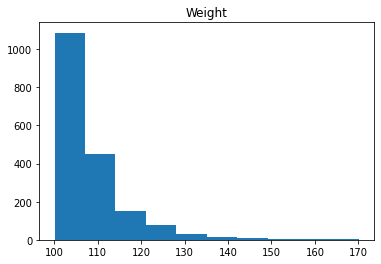

In [39]:
over100 = drop_height_df[drop_height_df['ITEM_F002']>100].copy()
plt.hist(over100['ITEM_F002'])
plt.title('Weight')
plt.show()

- 데이터를 종합적으로 판단하기 위해 키, 몸무게를 고려하여 판단

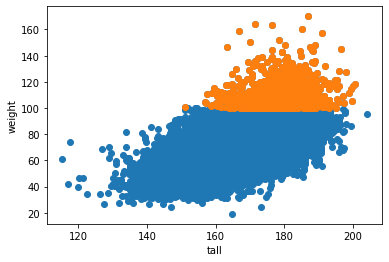

In [40]:
plt.scatter(drop_height_df['ITEM_F001'],drop_height_df['ITEM_F002'])
plt.scatter(over100['ITEM_F001'],over100['ITEM_F002'])
plt.xlabel('tall')
plt.ylabel('weight')
plt.show()

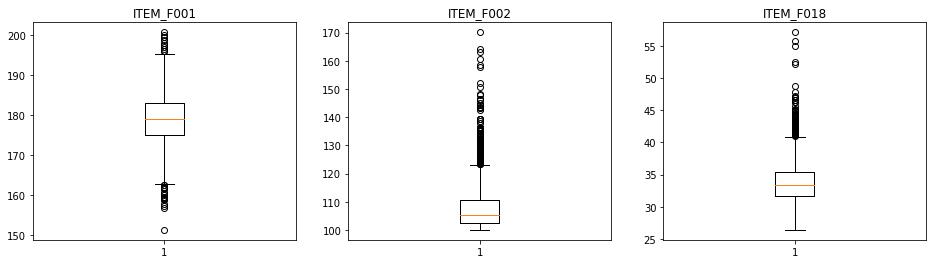

In [41]:
test = over100[['ITEM_F001','ITEM_F002','ITEM_F018']].reset_index(drop=True)
plt.figure(figsize=(16,4))
for i, column in enumerate(test):
    plt.subplot(1,3,i+1)
    plt.title(column)
    plt.boxplot(test[column])

- 몸무게가 높은 사람들은 대부분 키도 큰 것으로 확인, 정상 범주 이내라고 판단하여 제거하지 않음.

#### ITEM_F0018 (BMI)

- BMI 계산법 : $체중(kg) \over 신장(m)^2$

In [42]:
# BMI 계산 함수
# input : DataFrame
# ouput : DataFrame
def cal_bmi(x):
    return np.round(x['ITEM_F002'] / ((x['ITEM_F001']/100)**2),1)

In [43]:
drop_height_df['BMI'] = drop_height_df.apply(cal_bmi,axis=1)

In [44]:
drop_height_df

,TEST_AGE,CERT_GBN,TEST_YMD,TEST_SEX,ITEM_F001,ITEM_F002,ITEM_F018,PRE_EX,MAIN_EX,FINISH_EX,BMI
0,18,3등급,20210706,F,162.9,66.40,25.0,"깍지 끼고 상체 숙이기, 양팔 벌려 전신 비틀기","밴드 걸고 옆으로 누워 다리 올리기, 의자 앉아 다리로 짐볼 쥐기, 밴드 잡고 누워...","내전근 스트레칭, 대퇴사두근 스트레칭",25.0
1,17,참가증,20210706,M,183.4,101.90,30.3,"깍지 끼고 상체 숙이기, 양팔 벌려 전신 비틀기","밴드 걸고 옆으로 누워 다리 올리기, 의자 앉아 다리로 짐볼 쥐기, 밴드 잡고 누워...","내전근 스트레칭, 대퇴사두근 스트레칭",30.3
2,18,3등급,20210706,M,177.0,70.30,22.4,"상지 루틴 스트레칭, 하지 루틴 스트레칭","달리기, 걷기, 누워서 다리 들어올리기, 누워서 다리 좌우로 움직이기, 윗몸올리기 ...","전신 루틴 스트레칭, 배 스트레칭, 허리 스트레칭",22.4
3,18,참가증,20210706,M,180.1,71.00,21.9,"깍지 끼고 상체 숙이기, 양팔 벌려 전신 비틀기","밴드 걸고 옆으로 누워 다리 올리기, 의자 앉아 다리로 짐볼 쥐기, 밴드 잡고 누워...","내전근 스트레칭, 대퇴사두근 스트레칭",21.9
4,28,2등급,20210706,M,183.0,94.00,28.1,"걷기, 유산소 운동 전 동적 루틴 스트레칭","맨몸운동 루틴프로그램, 팔벌려뛰기, 사다리 옆으로 발 옮기기, 옆으로 펀치하기, ...",전신 루틴 스트레칭,28.1
...,...,...,...,...,...,...,...,...,...,...,...
198121,23,3등급,20170830,M,182.4,76.94,23.1,걷기,"달리기, 무릎 높여 제자리 달리기",전신 루틴 스트레칭,23.1
198122,22,참가증,20170819,F,156.8,52.60,21.4,"유산소 운동 전 동적 루틴 스트레칭, 상지 루틴 스트레칭","걷기, 수영, 스텝박스, 아쿠아로빅 운동 프로그램 루틴, 걷기, 자전거타기","등/어깨 뒤쪽 스트레칭, 하지 루틴 스트레칭, 엉덩이 스트레칭, 상지 루틴 스트레칭",21.4
198123,56,1등급,20170804,M,171.1,67.90,23.2,전신 루틴 스트레칭,"앉았다 일어서기, 의자 앞에서 앉았다 일어서기, 윗몸올리기 , 엎드려 버티기, 엎드...",전신 루틴 스트레칭,23.2
198124,76,2등급,20170801,M,165.3,64.30,23.5,"목 스트레칭, 등/어깨 뒤쪽 스트레칭, 상지 루틴 스트레칭, 하지 루틴 스트레칭","자전거타기, 수영, 달리기, 앉았다 일어서기, 팔굽혀펴기, 윗몸올리기 , 누워서 엉...","누워서 전신 뻗기, 엉덩이 스트레칭, 엉덩이 스트레칭, 몸통 스트레칭, 하지 루틴 ...",23.5


In [45]:
# 입력된 BMI와 키와 몸무게로 계산된 BMI가 같지 않은 행 추출
diff = drop_height_df[drop_height_df['ITEM_F018'] != drop_height_df['BMI']][['ITEM_F018','BMI']]
diff.T

,19025,19397,31744,32805,33548,37779,37861,40365,42699,49137,49252,55004,59573,63088,64048,64900,66157,69493,72694,79983,85595,88410,96680,111173,120424,124339,133363,136825,139165,145442,148749,148905,152238,162452,163658,163930,169621,174113,174118,178815,180051,181173,186377,187897,188217,189297,197996
ITEM_F018,27.4,23.8,26.3,22.3,18.8,26.3,24.7,22.9,21.2,18.8,21.3,23.8,31.3,21.3,22.3,18.8,23.8,23.8,18.8,18.8,21.3,18.8,23.8,18.8,21.3,18.8,18.8,23.8,21.3,23.8,23.8,23.8,18.8,18.8,31.3,18.8,21.3,22.3,17.3,23.8,18.8,21.3,26.3,18.8,18.8,23.8,23.8
BMI,25.9,23.7,26.2,21.2,18.7,26.2,24.2,22.5,17.9,18.7,21.2,23.7,31.2,21.2,22.2,18.7,23.7,23.7,18.7,18.7,21.2,18.7,23.7,18.7,21.2,18.7,18.7,23.7,21.2,23.7,23.7,23.7,18.7,18.7,31.2,18.7,21.2,22.2,17.2,23.7,18.7,21.2,26.2,18.7,18.7,23.7,23.7


입력값과 계산값의 오차가 1보다 큰 행은 이상치로 간주, 삭제 처리

In [46]:
condition = (diff['ITEM_F018']-diff['BMI'] > 1)
diff[condition]

,ITEM_F018,BMI
19025,27.4,25.9
32805,22.3,21.2
42699,21.2,17.9


In [47]:
# 몸무게와 키로 계산한 BMI 수치를 사용, 기존 열은 제거
drop_index = diff[condition].index
drop_bmi_df = drop_height_df.drop(drop_index).drop('ITEM_F018',axis=1).rename(columns={'BMI':'ITEM_F018'}).copy()
drop_bmi_df.head(4)

,TEST_AGE,CERT_GBN,TEST_YMD,TEST_SEX,ITEM_F001,ITEM_F002,PRE_EX,MAIN_EX,FINISH_EX,ITEM_F018
0,18,3등급,20210706,F,162.9,66.4,"깍지 끼고 상체 숙이기, 양팔 벌려 전신 비틀기","밴드 걸고 옆으로 누워 다리 올리기, 의자 앉아 다리로 짐볼 쥐기, 밴드 잡고 누워...","내전근 스트레칭, 대퇴사두근 스트레칭",25.0
1,17,참가증,20210706,M,183.4,101.9,"깍지 끼고 상체 숙이기, 양팔 벌려 전신 비틀기","밴드 걸고 옆으로 누워 다리 올리기, 의자 앉아 다리로 짐볼 쥐기, 밴드 잡고 누워...","내전근 스트레칭, 대퇴사두근 스트레칭",30.3
2,18,3등급,20210706,M,177.0,70.3,"상지 루틴 스트레칭, 하지 루틴 스트레칭","달리기, 걷기, 누워서 다리 들어올리기, 누워서 다리 좌우로 움직이기, 윗몸올리기 ...","전신 루틴 스트레칭, 배 스트레칭, 허리 스트레칭",22.4
3,18,참가증,20210706,M,180.1,71.0,"깍지 끼고 상체 숙이기, 양팔 벌려 전신 비틀기","밴드 걸고 옆으로 누워 다리 올리기, 의자 앉아 다리로 짐볼 쥐기, 밴드 잡고 누워...","내전근 스트레칭, 대퇴사두근 스트레칭",21.9


In [48]:
# 통계값 확인
drop_bmi_df[['TEST_AGE','ITEM_F001','ITEM_F002','ITEM_F018']].agg(['min','mean','median','max'])

,TEST_AGE,ITEM_F001,ITEM_F002,ITEM_F018
min,11.000000,115.400000,19.100000,7.000000
mean,43.676408,164.484108,64.847574,23.864877
median,42.000000,164.100000,63.300000,23.600000
max,99.000000,204.000000,170.120000,57.100000


#### Boxplot - Ater outlier processing

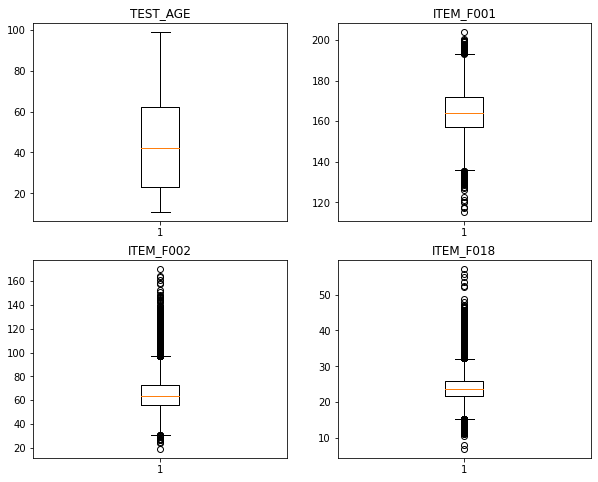

In [49]:
plt.figure(figsize=(10,8))
for i, column in enumerate(drop_bmi_df[numeric_columns]):
    plt.subplot(2,2,i+1)
    plt.title(column)
    plt.boxplot(drop_bmi_df[column])
plt.show()

- ITEM_F001과 ITEM_F018의 이상치가 많이 제거된 것을 알 수 있음

## User Grouping

In [ ]:
drop_bmi_df

,TEST_AGE,CERT_GBN,TEST_YMD,TEST_SEX,ITEM_F001,ITEM_F002,PRE_EX,MAIN_EX,FINISH_EX,ITEM_F018
0,18,3등급,20210706,F,162.9,66.40,"깍지 끼고 상체 숙이기, 양팔 벌려 전신 비틀기","밴드 걸고 옆으로 누워 다리 올리기, 의자 앉아 다리로 짐볼 쥐기, 밴드 잡고 누워...","내전근 스트레칭, 대퇴사두근 스트레칭",25.0
1,17,참가증,20210706,M,183.4,101.90,"깍지 끼고 상체 숙이기, 양팔 벌려 전신 비틀기","밴드 걸고 옆으로 누워 다리 올리기, 의자 앉아 다리로 짐볼 쥐기, 밴드 잡고 누워...","내전근 스트레칭, 대퇴사두근 스트레칭",30.3
2,18,3등급,20210706,M,177.0,70.30,"상지 루틴 스트레칭, 하지 루틴 스트레칭","달리기, 걷기, 누워서 다리 들어올리기, 누워서 다리 좌우로 움직이기, 윗몸올리기 ...","전신 루틴 스트레칭, 배 스트레칭, 허리 스트레칭",22.4
3,18,참가증,20210706,M,180.1,71.00,"깍지 끼고 상체 숙이기, 양팔 벌려 전신 비틀기","밴드 걸고 옆으로 누워 다리 올리기, 의자 앉아 다리로 짐볼 쥐기, 밴드 잡고 누워...","내전근 스트레칭, 대퇴사두근 스트레칭",21.9
4,28,2등급,20210706,M,183.0,94.00,"걷기, 유산소 운동 전 동적 루틴 스트레칭","맨몸운동 루틴프로그램, 팔벌려뛰기, 사다리 옆으로 발 옮기기, 옆으로 펀치하기, ...",전신 루틴 스트레칭,28.1
...,...,...,...,...,...,...,...,...,...,...
198121,23,3등급,20170830,M,182.4,76.94,걷기,"달리기, 무릎 높여 제자리 달리기",전신 루틴 스트레칭,23.1
198122,22,참가증,20170819,F,156.8,52.60,"유산소 운동 전 동적 루틴 스트레칭, 상지 루틴 스트레칭","걷기, 수영, 스텝박스, 아쿠아로빅 운동 프로그램 루틴, 걷기, 자전거타기","등/어깨 뒤쪽 스트레칭, 하지 루틴 스트레칭, 엉덩이 스트레칭, 상지 루틴 스트레칭",21.4
198123,56,1등급,20170804,M,171.1,67.90,전신 루틴 스트레칭,"앉았다 일어서기, 의자 앞에서 앉았다 일어서기, 윗몸올리기 , 엎드려 버티기, 엎드...",전신 루틴 스트레칭,23.2
198124,76,2등급,20170801,M,165.3,64.30,"목 스트레칭, 등/어깨 뒤쪽 스트레칭, 상지 루틴 스트레칭, 하지 루틴 스트레칭","자전거타기, 수영, 달리기, 앉았다 일어서기, 팔굽혀펴기, 윗몸올리기 , 누워서 엉...","누워서 전신 뻗기, 엉덩이 스트레칭, 엉덩이 스트레칭, 몸통 스트레칭, 하지 루틴 ...",23.5


In [ ]:
age_bins = [0,10,20,30,40,50,60,70,80,90,100]
pd.cut(unify_df['TEST_AGE'], 
       ['10세 미만','10대','20대','30대','40대','50대','60대','70대','80대','90대'])

0         (10, 20]
1         (10, 20]
2         (10, 20]
3         (10, 20]
4         (20, 30]
            ...   
198121    (20, 30]
198122    (20, 30]
198123    (50, 60]
198124    (70, 80]
198125    (50, 60]
Name: TEST_AGE, Length: 198126, dtype: category
Categories (9, interval[int64, right]): [(0, 10] < (10, 20] < (20, 30] < (30, 40] ... (50, 60] <
                                         (60, 70] < (70, 80] < (80, 90]]

# Data Preprocessing